# Алгоритм для игры в "Четыре в ряд"

In [1]:
import random
from collections import Counter
import numpy as np
import pandas as pd
from operator import itemgetter
from itertools import chain

import torch
import torch.nn.functional as F
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

## 1. Реализация правил игры

In [2]:
STRATEGIES = {0: 'Tie', 1: 'Vertical', 2: 'Horizontal', 3: 'Diagonal'}
PLAYERS = {-1: '2nd', 1: '1st', 0: 'Tie'}
# все победы равноценны (зеркальные награды для 1ого и 2ого участника)
REWARDS_EQUAL_1 = {-3: -1, -2: -1, -1: -1, 0: 0, 1: 1, 2: 1, 3: 1}
REWARDS_EQUAL_2 = {-3: 1, -2: 1, -1: 1, 0: 0, 1: -1, 2: -1, 3: -1}
# победы по горизонтали и диагонали оцениваются выше
REWARDS_HORIZ_1 = {-3: -1, -2: -2, -1: -3, 0: 0, 1: 1, 2: 2, 3: 3}

In [3]:
class ConnectFour:
    
    def __init__(self):
        self.board = np.zeros([6, 7])
        self.current_player = 1
        self.actions_history = []
        #self.game_states_history = []

    @property
    def legal_actions(self):
        return np.nonzero(self.board[0,:] == 0)[0]
    
    @property
    def last_move(self):
        last_action = self.actions_history[-1]
        row = np.nonzero(self.board[:, last_action])[0][0]
        return row, last_action
    
    @property
    def free_spots(self):
        return 6*7 - self.moves
    
    @property
    def moves(self):
        return np.count_nonzero(self.board)
    
    @property
    def state(self):
        state = self.board.flatten().reshape(1, -1)
        # state = np.where(state == -1, 2, state)
        return state
    
    def make_image(self):
        new_game = self.__class__()
        new_game.board = np.copy(self.board)
        new_game.current_player = self.current_player
        new_game.actions_history = self.actions_history[:]
        return new_game
    
    def get_free_row(self, action):
        x = np.argmax(self.board != 0, axis=0)
        x = np.where(x > 0, x-1, 6-1)
        return x[action]
        
    def make_move(self, action):
        if self.free_spots != 0:
            row = self.get_free_row(action)
            self.board[row, action] = self.current_player
            self.actions_history.append(action)
            # меняем до проверки на победу
            self.current_player *= -1
    
    def is_pos_diagonal_win(self):
        disks = 0
        # считаем слева вниз
        row, col = self.last_move
        while row < 6 and col >= 0 and self.board[row][col] == -self.current_player:
            disks += 1
            row += 1
            col -= 1
        # считаем справа вверх
        row, col = self.last_move
        while row >= 0 and col < 7 and self.board[row][col] == -self.current_player:
            disks += 1
            if disks-1 >= 4:
                return True
            row -= 1
            col += 1
        return False
    
    def is_neg_diagonal_win(self):
        disks = 0
        # считаем справа вниз
        row, col = self.last_move
        while row < 6 and col < 7 and self.board[row][col] == -self.current_player:
            disks += 1
            row += 1
            col += 1
        # считаем слева вверх
        row, col = self.last_move
        while row >= 0 and col >= 0 and self.board[row][col] == -self.current_player:
            disks += 1
            if disks-1 >= 4:
                return True
            row -= 1
            col -= 1
        return False        
    
    def is_horizontal_win(self):
        disks = 0
        # считаем влево
        row, col = self.last_move
        while col >= 0 and self.board[row][col] == -self.current_player:
            disks += 1
            col -= 1
        # считаем вправо
        row, col = self.last_move
        while col < 7 and self.board[row][col] == -self.current_player:
            disks += 1
            if disks-1 == 4:
                return True
            col += 1
        return False
    
    def is_vertical_win(self):
        disks = 0
        row, col = self.last_move
        # считаем вниз
        while row < 6 and self.board[row][col] == -self.current_player:
            disks += 1
            if disks == 4:
                return True
            row += 1
        return False
    
    @property
    def outcome(self):
        if self.is_vertical_win():
            return 1 * (-self.current_player)
        if self.is_horizontal_win():
            return 2 * (-self.current_player)
        if self.is_pos_diagonal_win() or self.is_neg_diagonal_win():
            return 3 * (-self.current_player)
        return 0
    
    @property
    def finished(self):
        if self.moves < 7:
            return False
        if self.moves == 6*7:
            return True
        else:
            if self.outcome != 0:
                return True
        return False
        
    def visualize_board(self):
        print('1 2 3 4 5 6 7')
        print('-------------')
        for i in range(6):
            row = []
            for value in self.board[i]:
                if value == 1:
                    row.append('x')
                elif value == -1:
                    row.append('o')
                else:
                    row.append('.')
            print(' '.join(el for el in row))
        print()

## 2. Алгоритм Monte Carlo tree search (MCTS)

https://en.wikipedia.org/wiki/Monte_Carlo_tree_search

https://www.youtube.com/watch?v=UXW2yZndl7U

https://habr.com/ru/post/282522/

In [4]:
class NodeMCTS:
    
    def __init__(self, game_state, coeff):
        self.parent = None
        self.children = []
        self.visit_counts = 0
        self.current_value = 0
        self.total_value = 0
        self.game_state = game_state
        self.coeff = coeff
        
    def is_leaf(self):
        return not self.children
                 
    def create_child(self, action):
        child_game_state = self.game_state.make_image()
        child_game_state.make_move(action)
        child_node = self.__class__(child_game_state, self.coeff)
        child_node.parent = self
        return child_node

    def choose_child(self):
        scores = []
        for child in self.children:
            if child.visit_counts == 0:
                return child
            else:
                scores.append(child.ucb_score)
        max_score_index = np.argmax(scores)
        return self.children[max_score_index]
    
    def expand(self):
        # нейросеть для предсказания наиболее перспективного дочернего узла в плане победы
        for action in self.game_state.legal_actions:
            child_node = self.create_child(action)
            self.children.append(child_node)
      
    @property
    def ucb_score(self):
        exploitation = self.total_value / self.visit_counts
        exploration = np.sqrt(np.log(self.parent.visit_counts) / self.visit_counts)
        return exploitation + self.coeff * exploration

In [5]:
class MCTS:
    
    def __init__(self, n_simulations=10, coeff=2, rewards=None):
        self.n_simulations = n_simulations
        self.coeff = coeff
        self.rewards = rewards 
        
    def load_game(self, game):
        game_image = game.make_image()
        self.root = NodeMCTS(game_image, self.coeff)
        self.root.expand()
    
    def predict(self):
        scores = [child.total_value / child.visit_counts for child in self.root.children]
        index = np.argmax(scores)
        return self.root.game_state.legal_actions[index]
    
    def predict_probs(self):
        scores = np.array([child.total_value / child.visit_counts for child in self.root.children])
        return np.exp(scores) / np.sum(np.exp(scores))
            
    def backpropagate(self, node):
        while node.parent is not None:
            node.parent.total_value += node.current_value
            node.parent.visit_counts += 1
            node = node.parent
            
    def select(self):
        node = self.root
        while not node.is_leaf():
            node = node.choose_child()
        return node
    
    def simulate(self, node):
        simulation = node.game_state.make_image()
        while not simulation.finished:
            # нейросеть для предсказания исхода игры без симуляции
            simulation_action = np.random.choice(simulation.legal_actions)
            simulation.make_move(simulation_action)
        outcome = self.rewards[simulation.outcome]
        node.current_value = outcome
        node.total_value += outcome
        node.visit_counts += 1
        
    def fit(self):
        for i in range(self.n_simulations):
            current_node = self.select()
            if current_node.visit_counts != 0:
                current_node.expand()
                if current_node.children:
                    first_child_node = current_node.children[0]
                    self.simulate(first_child_node)
                    self.backpropagate(first_child_node)
            else: 
                self.simulate(current_node)
                self.backpropagate(current_node)

### Вспомогательные функции

In [6]:
def simulate_game(player_1, player_2):
    
    game = ConnectFour()
    
    while not game.finished:
        
        if game.current_player == 1:
            player = player_1
        else:
            player = player_2
            
        player.load_game(game)
        player.fit()
        action = player.predict()
        game.make_move(action)
#         print('After action board')
#         game.visualize_board()
#         print()
#     print('Final board')
#     game.visualize_board()
#     print()
    return game.outcome

In [7]:
def simulate_games(player_1, player_2, n_games=100):
    outcomes = []
    for i in range(n_games):
        outcome = simulate_game(player_1, player_2)
        outcomes.append(outcome)
    return np.array(outcomes)

In [8]:
def get_dfs_for_plotting(player_1, player_2, n_games=100):
    outcomes = simulate_games(player_1, player_2, n_games=n_games)

    strats = np.abs(outcomes)
    players = np.where(outcomes > 0, 1, outcomes)
    players = np.where(players < 0, -1, players)

    df = pd.DataFrame(np.vstack([strats, players]).T, columns=['strategy', 'winner'])
    df['strategy'] = df['strategy'].map(STRATEGIES)
    df['winner'] = df['winner'].map(PLAYERS)
    new_df = df[df.strategy != 'Tie'].groupby(
        ['strategy', 'winner'])['winner'].count().rename('count').reset_index()
    return df, new_df


def get_simulated_games_info(player_1, player_2, n_games=100, plot=True):
    
    df, new_df = get_dfs_for_plotting(player_1, player_2, n_games=n_games)
    probs = df['winner'].value_counts(normalize=True)
    
    if plot:
        fig = plt.figure(figsize=(15, 5))
        gs = fig.add_gridspec(1, 2)

        # Соотношение побед
        fig.add_subplot(gs[0, 0])
        order = df.winner.sort_values().unique()
        sns.countplot(df['winner'], data=df, order=order)

        # Соотношение по типам побед
        fig.add_subplot(gs[0, 1])
        order = ['Vertical', 'Horizontal', 'Diagonal']
        hue_order = new_df.winner.sort_values().unique()
        sns.barplot(x='strategy', y='count', hue='winner', data=new_df, order=order, hue_order=hue_order)

        plt.show()
        print(probs)
    
    return probs.sort_index(ascending=True).values

In [9]:
# генератор случайных позиций

class RandomPlayer:
    
    def load_game(self, game):
        self.game = game.make_image()
        
    def fit(self):
        pass
    
    def predict(self):
        return np.random.choice(self.game.legal_actions)
    
    def predict_probs(self):
        n_actions = len(self.game.legal_actions)
        return np.array([1 / n_actions for i in range(n_actions)])

## 3. Оценка эффективности и корректности работы алгоритма MCTS

### a)  Генератор случайных позиций против самого себя

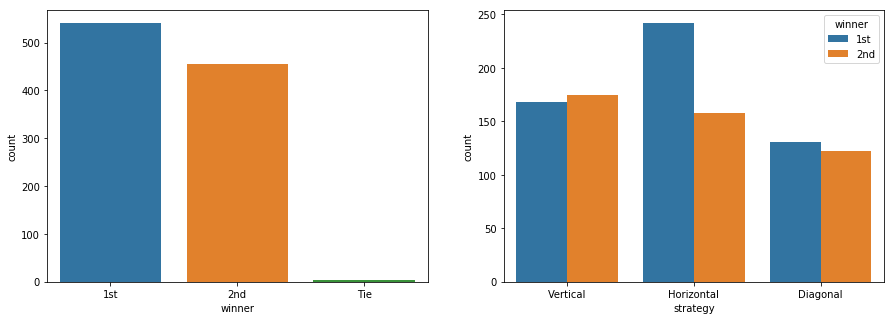

1st    0.541
2nd    0.455
Tie    0.004
Name: winner, dtype: float64


In [10]:
probs = get_simulated_games_info(RandomPlayer(), RandomPlayer(), n_games=1000)

Игрок, начинающий первым, имеет преимущество: ~55% к ~45%

### b)  Алгоритм MCTS против генератора случайных позиций (алгоритм играет первым номером)

In [14]:
monte_carlo_player = MCTS(n_simulations=100, coeff=2, rewards=REWARDS_EQUAL_1)

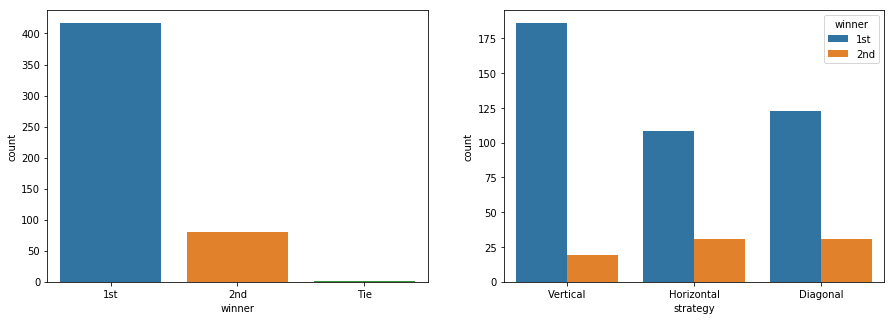

1st    0.834
2nd    0.162
Tie    0.004
Name: winner, dtype: float64


In [15]:
probs = get_simulated_games_info(monte_carlo_player, RandomPlayer(), n_games=500)

Алгоритм MCTS показывает существенный прирост процента побед: >70% против базовых 55%

### с)  Алгоритм MCTS против генератора случайных позиций (алгоритм играет вторым номером)

In [16]:
monte_carlo_player = MCTS(n_simulations=100, coeff=2, rewards=REWARDS_EQUAL_2)

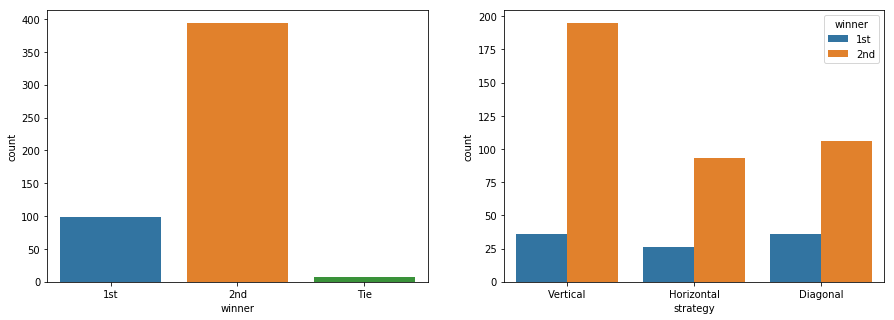

2nd    0.788
1st    0.196
Tie    0.016
Name: winner, dtype: float64


In [17]:
probs = get_simulated_games_info(RandomPlayer(), monte_carlo_player, n_games=500)

### d)  Алгоритм MCTS против генератора случайных позиций (вертикали оцениваются меньше всего)

In [18]:
monte_carlo_player = MCTS(n_simulations=100, coeff=2, rewards=REWARDS_HORIZ_1)

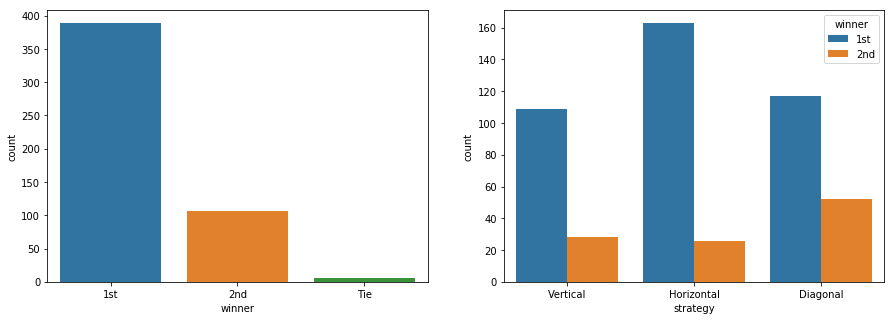

1st    0.778
2nd    0.212
Tie    0.010
Name: winner, dtype: float64


In [19]:
probs = get_simulated_games_info(monte_carlo_player, RandomPlayer(), n_games=500)

Высокий процент побед сохранился: >70% против базовых 55%. Количество вертикальных побед стало меньше, чем горизонтальных и диагональных. Таким образом, алгоритм корректно реагирует на изменение наград.

### d)  Зависимость процента побед алгоритма MCTS от числа симуляций

In [ ]:
# n_simulations = np.linspace(10, 510, 5, endpoint=False)
# n_games = 500

# total_outcomes = []

# for n_sim in n_simulations:
#     monte_carlo_player = MCTS(n_simulations=int(n_sim), coeff=2, rewards=REWARDS_EQUAL)
#     random_player = RandomPlayer()
#     probs = get_simulated_games_info(monte_carlo_player, RandomPlayer(), n_games=n_games, plot=False)
#     total_outcomes.append(probs[0])
#     print([c.visit_counts for c in monte_carlo_player.root.children])
#     print([c.total_value for c in monte_carlo_player.root.children])
#     print(probs[0])

## 4. Нейронная сеть для предсказания действия в текущей ситуации

### Реализация

In [20]:
class PolicyNet(nn.Module):
    
    def __init__(self, input_size=42, n_classes=7, hidden_size=100, 
                 learning_rate=1e-3, batch_size=200, n_epochs=5):
        
        super().__init__()
        
        self.input_size = input_size
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        
        self.fc1 = nn.Linear(self.input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.do2 = nn.Dropout(p=0.5)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        
        self.fc4 = nn.Linear(hidden_size, self.n_classes)
    
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.loss = nn.CrossEntropyLoss()
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
        self.accuracy_history_train = []
        self.loss_history_train = []
        self.accuracy_history_test = []
        self.loss_history_test = []
    
    def forward(self, X):
        # 1
        X = self.fc1(X)
        X = F.relu(X)
        X = self.bn1(X)
        # 2
        X = self.fc2(X)
        X = F.relu(X)
        X = self.do2(X)
        X = self.bn2(X)
        # 3
        X = self.fc3(X)
        X = F.relu(X)
        X = self.bn3(X)
        # 4
        X = self.fc4(X)
        return X
    
    def load_data(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, shuffle=True)
        X_train = torch.FloatTensor(X_train)
        y_train = torch.LongTensor(y_train)
        X_test = torch.FloatTensor(X_test)
        y_test = torch.LongTensor(y_test)
        data_train = torch.utils.data.TensorDataset(X_train, y_train)
        self.data_loader_train = torch.utils.data.DataLoader(
            data_train, 
            batch_size=self.batch_size, 
            shuffle=True
        )
        self.X_test = X_test
        self.y_test = y_test
        
    def train_model(self):
        for epoch in range(self.n_epochs):
            self.train()
            loss_epoch = []
            accuracy_epoch = []
            for i, (X_batch, y_batch) in enumerate(self.data_loader_train):
                self.optimizer.zero_grad()
                y_batch = y_batch.to(self.device)
                preds = self.forward(X_batch.to(self.device))
                loss_batch = self.loss(preds, y_batch)
                # loss history
                loss_epoch.append(loss_batch.item())
                # accuracy history
                preds = F.softmax(preds, dim=1)
                preds = torch.argmax(preds, dim=1)
                good_preds = torch.where(preds != y_batch, 
                                          torch.tensor([0.]).to(self.device), 
                                          torch.tensor([1.]).to(self.device))
                accuracy_batch = torch.mean(good_preds)
                accuracy_epoch.append(accuracy_batch.item())
                # backprop
                loss_batch.backward()
                self.optimizer.step()
            # epoch history
            self.loss_history_train.append(np.mean(loss_epoch))
            self.accuracy_history_train.append(np.mean(accuracy_epoch))
            
            self.eval()
            with torch.no_grad():
                y_test = self.y_test.to(self.device)
                preds_test = self.forward(self.X_test.to(self.device))
                loss_test = self.loss(preds_test, y_test)
                preds_test = F.softmax(preds_test, dim=1)
                preds_test = torch.argmax(preds_test, dim=1)
                good_preds_test = torch.where(preds_test != y_test, 
                                          torch.tensor([0.]).to(self.device), 
                                          torch.tensor([1.]).to(self.device))
                accuracy_test = torch.mean(good_preds_test)
                self.loss_history_test.append(loss_test.item())
                self.accuracy_history_test.append(accuracy_test)
            

        print(f'Loss:\t\t{self.loss_history_train[-1]}\t{self.loss_history_test[-1]}')
        print(f'Accuracy:\t{self.accuracy_history_train[-1]}\t{self.accuracy_history_test[-1]}')
            
        print()
        
    def predict(self, state):
        self.eval()
        state = torch.FloatTensor(state)
        with torch.no_grad():
            preds = self.forward(state.to(self.device))
            preds = F.softmax(preds, dim=1)
            cols = torch.argsort(preds, descending=True)[0].tolist()
        return cols
    
    def predict_probs(self, state):
        self.eval()
        state = torch.FloatTensor(state)
        with torch.no_grad():
            preds = self.forward(state.to(self.device))
            probs = F.softmax(preds, dim=1)
        return probs

In [21]:
class ReinforcedPlayer:
    
    def __init__(self):
        self.network = PolicyNet(
            input_size=42, 
            n_classes=7, 
            hidden_size=1000,
            learning_rate=1e-3, 
            batch_size=1024,
            n_epochs=5
        )
        
    def fit(self):
        pass
    
    def load_game(self, game):
        self.game = game.make_image()
        
    def train(self):
        self.network.train_model()
        
    def load_data(self, X, y):
        self.network.load_data(X, y)
    
    def predict(self):
        probs = self.predict_probs()
        index = np.argmax(probs)
        return self.game.legal_actions[index]
        
    def predict_probs(self):
#         state = self.game.board.flatten().reshape(1, -1)
#         state = np.where(state == -1, 2, state)
        probs = self.network.predict_probs(self.game.state)
        probs = probs.cpu()[0].numpy()
        new_probs = probs[self.game.legal_actions]
        new_probs = new_probs/np.sum(new_probs)
        return new_probs

### Вспомогательные функции для тренировки сети

In [22]:
def play_game(player_1, player_2):
    
    game = ConnectFour()
    
    game_states_1 = []
    game_actions_1 = []
    game_states_2 = []
    game_actions_2 = []

    while not game.finished:
        current_player = game.current_player
        if current_player == 1:
            game_states_1.extend(chain.from_iterable(game.state))
            player_1.load_game(game)
            column = np.random.choice(game.legal_actions, p=player_1.predict_probs())
            game.make_move(column)
            game_actions_1.append(column)
        if current_player == -1:
            game_states_2.extend(chain.from_iterable(game.state))
            player_2.load_game(game)
            column = np.random.choice(game.legal_actions, p=player_2.predict_probs())
            game.make_move(column)
            game_actions_2.append(column)
    
    return game_states_1, game_actions_1, game_states_2, game_actions_2, game.outcome, game.moves

In [23]:
def play_games(player_1, player_2, n_games=100):
    
    states_1 = []
    actions_1 = []
    states_2 = []
    actions_2 = []
    winners = []
    moves = []
    strategies = []
    
    for i in range(n_games):

        game_st_1, game_act_1, game_st_2, game_act_2, outcome, game_moves = play_game(player_1, player_2)        
        
        states_1.append(game_st_1)
        actions_1.append(game_act_1)
        states_2.append(game_st_2)
        actions_2.append(game_act_2)
        if outcome > 0:
            winners.append(1)
        elif outcome < 0:
            winners.append(-1)
        else:
            winners.append(0)
        moves.append(game_moves)
        strategies.append(np.abs(outcome))
        
    return states_1, actions_1, states_2, actions_2, winners, moves, strategies

In [24]:
def get_dataset_from_game_data(states, actions, winners, moves, strategies, player=1):
    df = pd.DataFrame(zip(moves, strategies, winners), columns=['moves', 'strategy', 'winner'])
    
#     print(df.winner.value_counts(normalize=True))
#     print()
#     print(df[df.winner == player].strategy.value_counts())
#     print()
    
    games_indices = df[(df.winner == player) & (df.moves >= 15)].index.to_list()
    X = itemgetter(*games_indices)(states)
    y = itemgetter(*games_indices)(actions)
    X = np.fromiter(chain.from_iterable(X), int).reshape(-1, 6*7)
    y = np.fromiter(chain.from_iterable(y), int)
    return X, y

In [25]:
def train_policy_network(player_1, player_2, n_rounds=10, n_games=1000):

    for i in range(n_rounds):
        print(i)

        st_1, act_1, st_2, act_2, winners, moves, strategies = play_games(player_1, player_2, n_games=n_games)

        X1, y1 = get_dataset_from_game_data(st_1, act_1, winners, moves, strategies, player=1)
        X2, y2 = get_dataset_from_game_data(st_2, act_2, winners, moves, strategies, player=-1)

        player_1.load_data(X1, y1)
        player_1.train()

        player_2.load_data(X2, y2)
        player_2.train()

### Тренируем нейросеть

In [26]:
player_1 = ReinforcedPlayer()
player_2 = ReinforcedPlayer()

In [27]:
train_policy_network(player_1, player_2, n_rounds=20, n_games=10000)

0
Loss:		1.923595064395183	1.9746569395065308
Accuracy:	0.19055285767928973	0.15533308684825897

Loss:		1.9120465715726216	1.968962550163269
Accuracy:	0.2019016593694687	0.15751083195209503

1
Loss:		1.868173552883996	1.930829405784607
Accuracy:	0.23955965042114258	0.1982627511024475

Loss:		1.850785739960209	1.9236538410186768
Accuracy:	0.24926814917595155	0.2094307392835617

2
Loss:		1.8022775716251798	1.87816321849823
Accuracy:	0.27354323863983154	0.2404281198978424

Loss:		1.7801766134798527	1.8846911191940308
Accuracy:	0.2876660153269768	0.24548973143100739

3
Loss:		1.7395874398095268	1.815104603767395
Accuracy:	0.3019355024610247	0.2737187147140503

Loss:		1.674501422792673	1.7798725366592407
Accuracy:	0.3375604972243309	0.29355815052986145

4
Loss:		1.651709845571807	1.7786484956741333
Accuracy:	0.3493878525314909	0.2994235157966614

Loss:		1.6126762014446836	1.7309260368347168
Accuracy:	0.36727120569258026	0.32471224665641785

5
Loss:		1.5540200717308943	1.7008488178253174
Acc

## 5. Оценка корректности работы нейросети

### a)  Нейросеть против генератора случайных позиций (нейросеть играет первым номером)

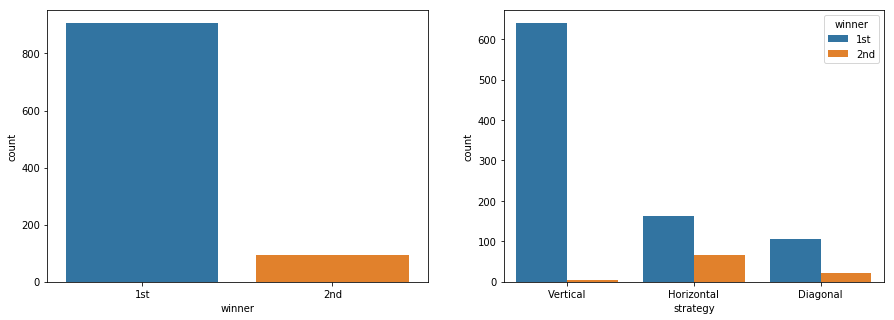

1st    0.907
2nd    0.093
Name: winner, dtype: float64


In [28]:
probs = get_simulated_games_info(player_1, RandomPlayer(), n_games=1000)

### b)  Нейросеть против генератора случайных позиций (нейросеть играет вторым номером)

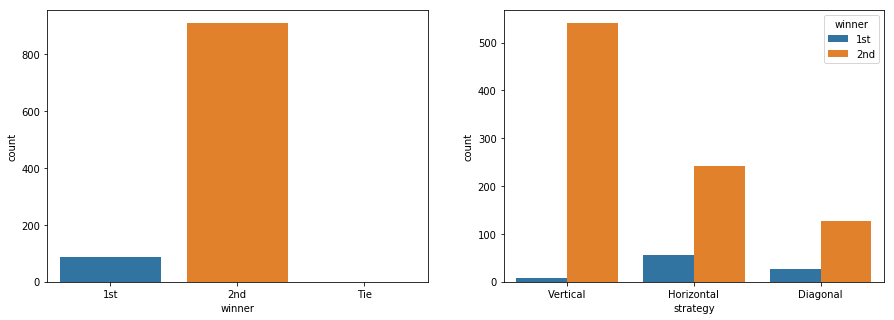

2nd    0.911
1st    0.088
Tie    0.001
Name: winner, dtype: float64


In [45]:
probs = get_simulated_games_info(RandomPlayer(), player_2, n_games=1000)

### c)  Нейросеть против алгоритма MCTS (нейросеть играет первым номером)

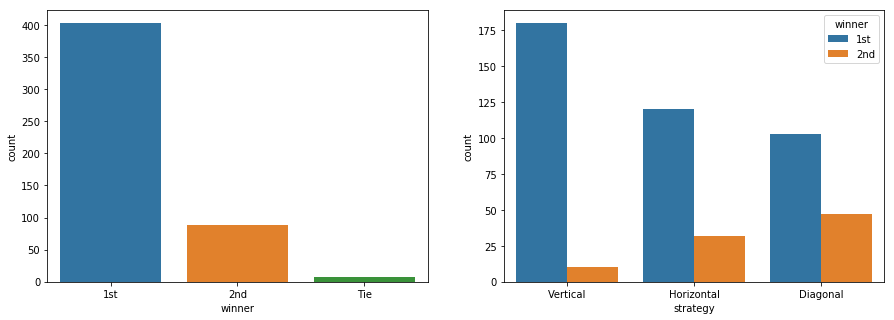

1st    0.806
2nd    0.178
Tie    0.016
Name: winner, dtype: float64


In [30]:
monte_carlo_player = MCTS(n_simulations=100, coeff=2, rewards=REWARDS_EQUAL_2)
probs = get_simulated_games_info(player_1, monte_carlo_player, n_games=500)

### d)  Нейросеть против алгоритма MCTS (нейросеть играет вторым номером)

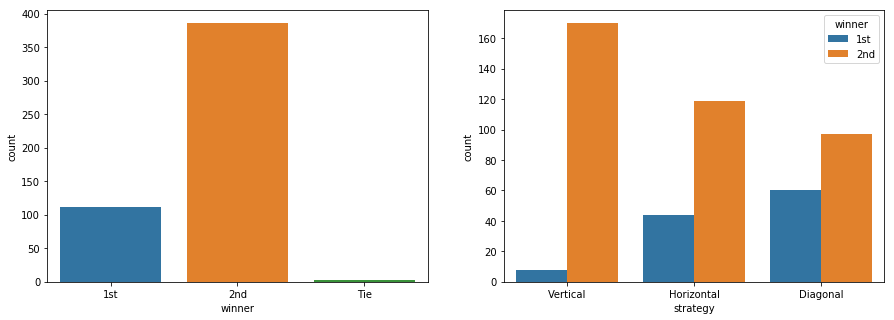

2nd    0.772
1st    0.224
Tie    0.004
Name: winner, dtype: float64


In [31]:
monte_carlo_player = MCTS(n_simulations=100, coeff=2, rewards=REWARDS_EQUAL_1)
probs = get_simulated_games_info(monte_carlo_player, player_2, n_games=500)

## 6. Объединение алгоритма MCTS и нейросети

Используем нейросеть в стадии "expand" алгоритма MCTS. Вместо автоматического расширения рассматриваемого узла на допустимое количество дочерних узлов (game.legal_actions) создадим с помощью нейросети только один дочерний узел с максимальной вероятностью выигрыша партии. Это сузит пространство поиска оптимального хода в ширину, фокусируя внимание алгоритма MCTS на наилучших путях в дереве.

In [32]:
class NodePolicyNetwork(NodeMCTS):
    
    def expand(self, action):
        child_node = self.create_child(action)
        self.children.append(child_node)

In [67]:
class PolicyNetworkMCTS(MCTS):
    
    def __init__(self, policy_network, n_simulations=10, coeff=2, rewards=None):
        self.n_simulations = n_simulations
        self.coeff = coeff
        self.rewards = rewards
        # две сети - по одной на каждую сторону
        self.policy_network = policy_network
        
    def expand_root(self):
        for action in self.root.game_state.legal_actions:
            child_node = self.root.create_child(action)
            self.root.children.append(child_node)
        
    def load_game(self, game):
        game_image = game.make_image()
        self.root = NodePolicyNetwork(game_image, self.coeff)
        self.expand_root()
      
    def fit(self):
        for i in range(self.n_simulations):
            current_node = self.select()
            if current_node.visit_counts != 0:
                if current_node.game_state.moves == 42:
                    continue
                if current_node.game_state.finished:
                    continue
                #если игра закончена?    
      
                self.policy_network.load_game(current_node.game_state)
#                 self.policy_network.game.visualize_board()
#                 probs = self.policy_network.predict_probs()
#                 action = np.random.choice(current_node.game_state.legal_actions, p=probs)
                action = self.policy_network.predict()
                current_node.expand(action)
                if current_node.children:
                    first_child_node = current_node.children[0]
                    self.simulate(first_child_node)
                    self.backpropagate(first_child_node)
            else: 
                self.simulate(current_node)
                self.backpropagate(current_node)

### a) Алгоритм против генератора случайных позиций (алгоритм играет первым номером)

In [68]:
mcts_pn_player = PolicyNetworkMCTS(player_1, n_simulations=100, coeff=2, rewards=REWARDS_EQUAL_1)

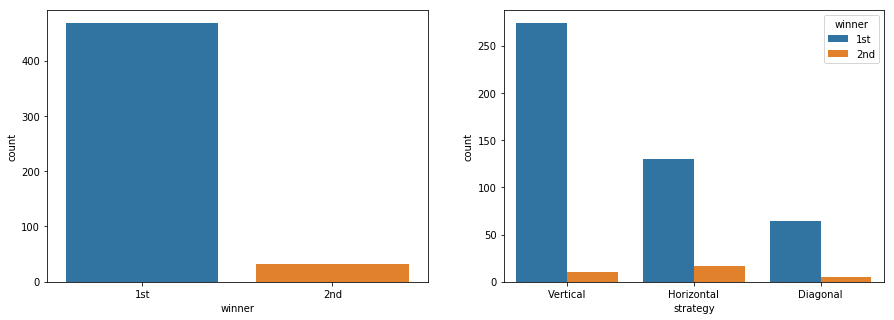

1st    0.936
2nd    0.064
Name: winner, dtype: float64


In [69]:
probs = get_simulated_games_info(mcts_pn_player, RandomPlayer(), n_games=500)

### b) Алгоритм против генератора случайных позиций (алгоритм играет вторым номером)

In [116]:
mcts_pn_player = PolicyNetworkMCTS(player_2, n_simulations=100, coeff=2, rewards=REWARDS_EQUAL_2)

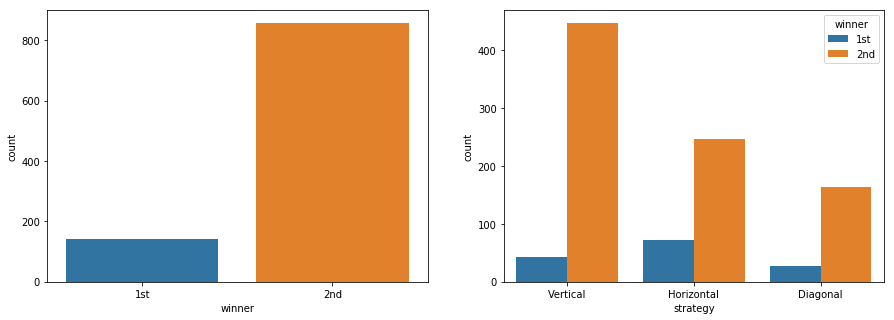

2nd    0.858
1st    0.142
Name: winner, dtype: float64


In [117]:
probs = get_simulated_games_info(RandomPlayer(), mcts_pn_player, n_games=1000)